In [1]:
#
# Jupyter python notebook to estimate ARGO Oxygen Correction.
# DOXY_ADJUSTED is corrected via the correction of the partial pressure PPOX as in 'Bittig and al (2018)'
# https://dx.doi.org/10.3389/fmars.2017.00429

#instruction to be able to zoom on matplotlib figure
%matplotlib widget 

# Path to LOCODOX python
import sys
sys.path.insert(0,'/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/source')

# Import python module
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date
import copy
import pwlf

# Import module developped for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, copy_attr, write_ASCII_file
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_Gain_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa, plot_Theta_S, plot_CTD_Argo_Pos, plot_cmp_corr_NCEP_with_error, plot_cmp_corr_WOA_with_error
from m_read_write_netcdf import corr_file

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_12903/3437599435.py:24: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#####################
# Initialization.
###################

# Results Directory.
# The BD files and the ASCII result file ill be created in this directory.
###################################################
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
# ASCII file root containing the different corrections estimated
racine_res = 'locodox_res_'

# Relative error to be written in the BD files
percent_relative_error = 2.0


# Which plot ?
###############
# info_plot = 1 : all plots
# info_plot = 0 : not all plots are created.
info_plot = 1 
# Figures Directory
rep_fic_fig = '/Users/chemon/tmp' #'/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/figures'

# ARGO Directory : contains 1 subdirectory by float.
# In the Argo float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
# WMO Float (string format) to be corrected / Cycles to be used
#################################################################
# Argo directory
#rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
# Argo float
#num_float = '6902882' 
num_float = '6902807'
# Cycle to use to estimate the correction
first_cycle_to_use = 1
last_cycle_to_use = 400

#
# sensor_aanderaa = 1 if aanderaa sensor, 0 if rinko sensor
sensor_aanderaa = 1
if sensor_aanderaa == 1:
    racine_res = racine_res + '_aanderaa_' 
    pcoef2 = 0.00022
    pcoef3 = 0.0419
else:
    racine_res = racine_res + '_rinko_' 
    pcoef2 = 0
    pcoef3 = 0.04

    
# Complete ASCII file name
fic_res_ASCII = os.path.join(rep_fic_res,racine_res + num_float)


# Which ARGO variables (PRES/PSAL/TEMP) to be used to estimate correction.
#################################################
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2
# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]
# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

# CTD comparison to estimate a supplement gain.
##################################################
# cmp_ctd = 1 : we used CTD, 0 otherwise
cmp_ctd = 1
# rep_ctd : CTD directory
#rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
#fic_ctd = ['ovid18_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
#num_cycle = np.array([3]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
#num_ctd = np.array([105]) 


rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
fic_ctd = ['rr17_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
num_cycle = np.array([1]) #np.array([5]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
num_ctd = np.array([26])  #np.array([7]) 

# Pressure effect 
###################
# Pressure for pressure effect estimation. We use pressure > pressure_threshold
pressure_threshold = 1000  

# Bathymetry plot
# Bathymetry file
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
#  Dataset associated
ds_bathy = xr.open_dataset(fic_bathy)
# extension for Position plot
extend_lon_lat = 0.5
# Depth for bathymetry contouring
depths = np.arange(-7000,500,500)

# WOA correction
##################
# fic_woa : WOA file
# Tis file contains the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# This file is created by an internal LOPS routine. It can change.
#
# WOA file
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
# Min and max pressure used to estimate WOA correction. 
min_pres_interp = 0
max_pres_interp = 25

# NCEP Correction
######################
# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

In [3]:
# Read ARGO files 
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/argo/gdac/dac/coriolis/6902807/6902807_meta.nc
/Volumes/argo/gdac/dac/coriolis/6902807/6902807_Sprof.nc
/Volumes/argo/gdac/dac/coriolis/6902807/6902807_Rtraj.nc


In [4]:
# Select the cycles to be used
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [5]:
# Chech ds_argo_Sprof
ds_argo_Sprof

<xarray.Dataset> Size: 68MB
Dimensions:                       (N_PROF: 272, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 2012)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     (N_PROF) object 2kB 'Argo synthetic profile...
    FORMAT_VERSION                (N_PROF) object 2kB '1.0 ' '1.0 ' ... '1.0 '
    HANDBOOK_VERSION              (N_PROF) object 2kB '1.2 ' '1.2 ' ... '1.2 '
    REFERENCE_DATE_TIME           (N_PROF) datetime64[ns] 2kB 1950-01-01 ... ...
    DATE_CREATION                 (N_PROF) datetime64[ns] 2kB 2024-12-05T12:1...
    DATE_UPDATE                   (N_PROF) datetime64[ns] 2kB 2024-12-05T12:1...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 2MB 271.0 ... nan
    DOXY_QC                       (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 ... 0.0
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 2MB 0.0 nan ... nan
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 2MB nan nan ... nan
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 ... 0.0
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 2MB nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:15:43Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

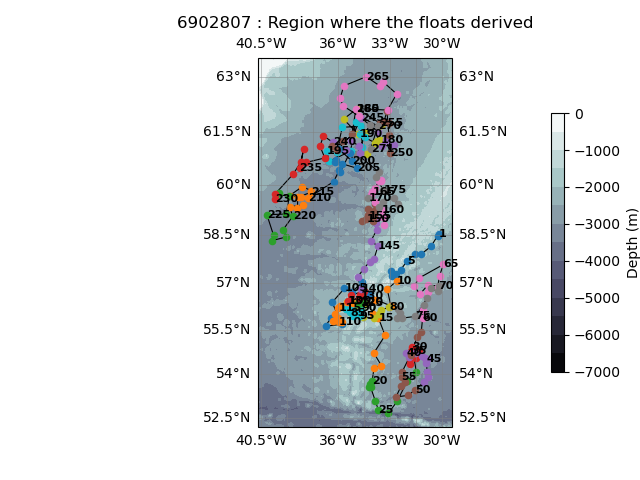

In [6]:
# Maps plotting
if info_plot==1:
    ds_bathy = xr.open_dataset(fic_bathy)
    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_pos.png'))

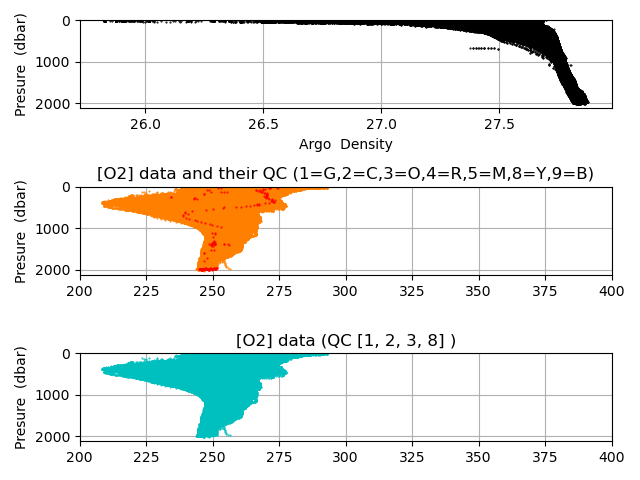

In [7]:
# DOXY_QC plot with PRES/PSAL/TEMP
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc.png'))

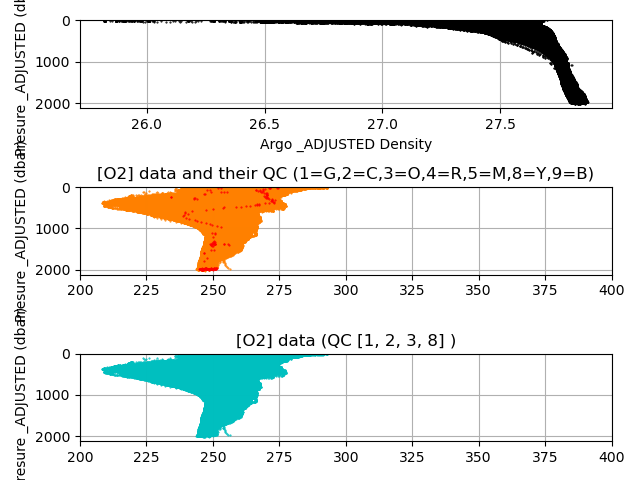

In [8]:
# Same with DATA ADJUSTED (PRES,PSAL,TEMP)
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc_PTS_adjusted.png'))

PRES
TEMP
PSAL


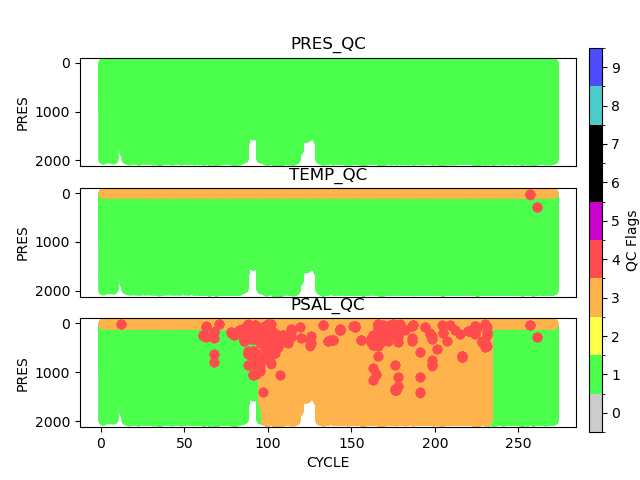

In [9]:
# PRES/PSAL/TEMP QC
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_QC.png'))

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


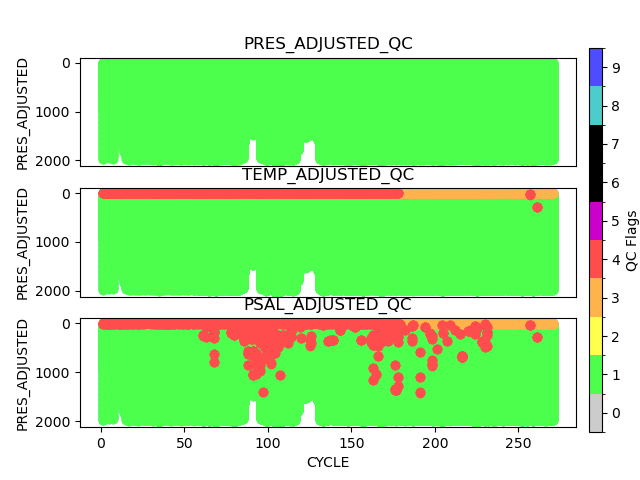

In [10]:
# Same with adjusted DATA
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_Adjusted_QC.png'))

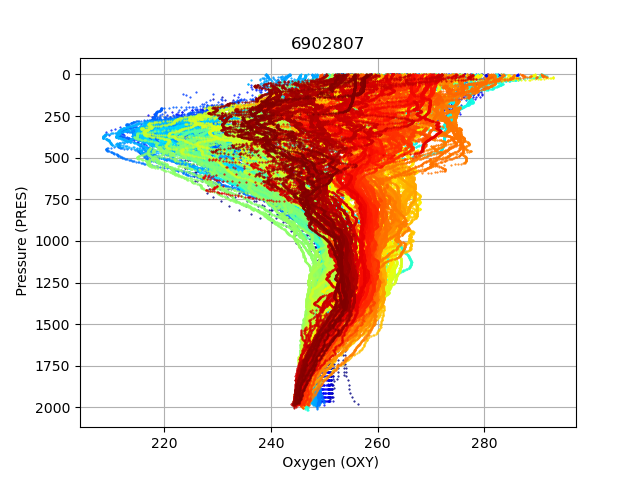

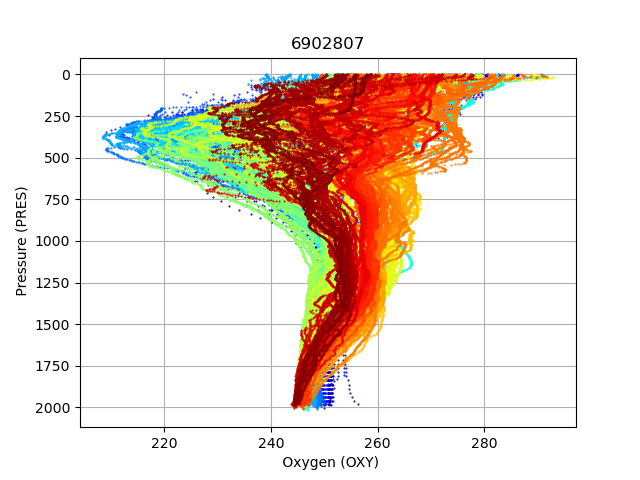

In [11]:
# DOXY RAW DATA
_=plot_DOXY_cycle(ds_argo_Sprof,qc_keep=[1,2,3,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_cycle.png'))
_=plot_DOXY_cycle(ds_argo_Sprof)


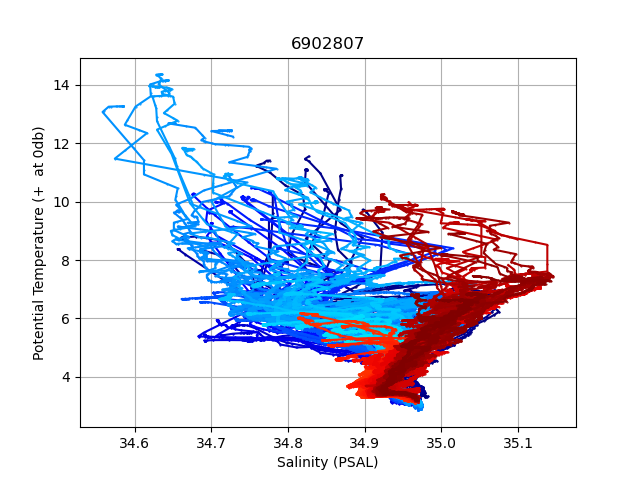

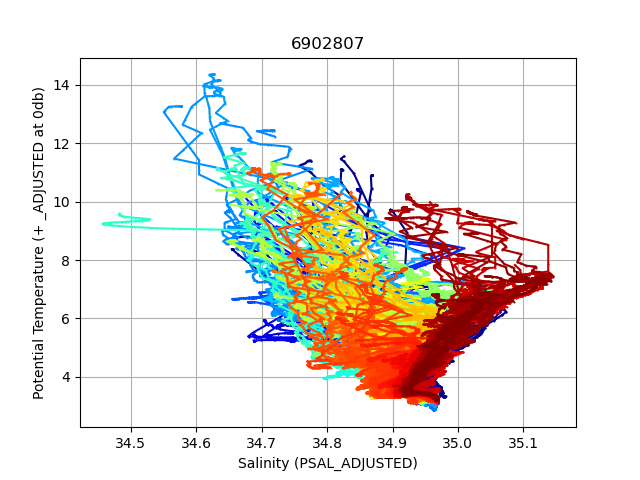

In [12]:
# Theta/S
#_=plot_Theta_S(ds_argo_Sprof)
#_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED')
_=plot_Theta_S(ds_argo_Sprof,qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S.png'))
_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED',qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S_adjusted.png'))



In [13]:
# Launch data
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2017-07-24T20:50:00.000000000
-0.291


In [14]:
# Delta time from launch date
delta_T_sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)
delta_T_sprof

<xarray.DataArray 'JULD' (N_PROF: 272)> Size: 2kB
array([1.19444444e-01, 1.38194444e+00, 1.14038194e+01, 2.14055556e+01,
       3.12802083e+01, 4.13486111e+01, 5.14003472e+01, 6.13805556e+01,
       7.14052083e+01, 8.14006944e+01, 9.13954861e+01, 1.01401389e+02,
       1.11422569e+02, 1.21402083e+02, 1.31401042e+02, 1.41384028e+02,
       1.51392014e+02, 1.61390278e+02, 1.71390625e+02, 1.81388889e+02,
       1.91382292e+02, 2.01384028e+02, 2.11388542e+02, 2.21387500e+02,
       2.31388542e+02, 2.41391667e+02, 2.51392708e+02, 2.61391667e+02,
       2.71386458e+02, 2.81387500e+02, 2.91392014e+02, 3.01388889e+02,
       3.11390625e+02, 3.21387500e+02, 3.31392708e+02, 3.41384722e+02,
       3.51391319e+02, 3.61390278e+02, 3.71388542e+02, 3.81385417e+02,
       3.91388542e+02, 4.01394444e+02, 4.11391319e+02, 4.21387500e+02,
       4.31394097e+02, 4.41386806e+02, 4.51389931e+02, 4.61392361e+02,
       4.71388542e+02, 4.81389583e+02, 4.91385764e+02, 5.01388889e+02,
       5.11389236e+02, 5.21394444e+02, 5.31393403e+02, 5.41398611e+02,
       5.51393403e+02, 5.61394792e+02, 5.71394097e+02, 5.81391319e+02,
       5.91389236e+02, 6.01396181e+02, 6.11387847e+02, 6.21392708e+02,
       6.31390625e+02, 6.41390625e+02, 6.51394097e+02, 6.61394097e+02,
       6.71392708e+02, 6.81386458e+02, 6.91391319e+02, 7.01392708e+02,
       7.11387153e+02, 7.21392708e+02, 7.31392708e+02, 7.41388542e+02,
       7.51388542e+02, 7.61394097e+02, 7.71394792e+02, 7.81391319e+02,
...
       1.91138924e+03, 1.92138993e+03, 1.93139132e+03, 1.94139132e+03,
       1.95139410e+03, 1.96138715e+03, 1.97139340e+03, 1.98138924e+03,
       1.99139132e+03, 2.00139479e+03, 2.01139549e+03, 2.02139340e+03,
       2.03139201e+03, 2.04139201e+03, 2.05139549e+03, 2.06139479e+03,
       2.07139132e+03, 2.08139201e+03, 2.09139062e+03, 2.10139271e+03,
       2.11139340e+03, 2.12139271e+03, 2.13139271e+03, 2.14139340e+03,
       2.15139410e+03, 2.16118750e+03, 2.17097465e+03, 2.18077222e+03,
       2.19055937e+03, 2.20034861e+03, 2.21014062e+03, 2.21993264e+03,
       2.22972882e+03, 2.23952014e+03, 2.24930660e+03, 2.25910000e+03,
       2.26889201e+03, 2.27868264e+03, 2.28847951e+03, 2.29826528e+03,
       2.30805937e+03, 2.31785069e+03, 2.32763785e+03, 2.33743264e+03,
       2.34722951e+03, 2.35701806e+03, 2.36680937e+03, 2.37660000e+03,
       2.38639340e+03, 2.39618958e+03, 2.40598299e+03, 2.41577083e+03,
       2.42556076e+03, 2.43535278e+03, 2.44513993e+03, 2.45493958e+03,
       2.46472674e+03, 2.47451944e+03, 2.48431354e+03, 2.49410486e+03,
       2.50389271e+03, 2.51368472e+03, 2.52347882e+03, 2.53327014e+03,
       2.54305937e+03, 2.55285417e+03, 2.56264271e+03, 2.57243611e+03,
       2.58222951e+03, 2.59202222e+03, 2.60181424e+03, 2.61160625e+03,
       2.62139410e+03, 2.63119167e+03, 2.64098160e+03, 2.65077500e+03,
       2.66056979e+03, 2.67035972e+03, 2.68014896e+03, 2.68995486e+03])
Dimensions without coordinates: N_PROF

In [15]:
################################## 
# Correction estimated with WOA
##################################
# ARGO data needed for WOA correction.
# ds_argo contains variables needed to estimate correction with WOA.
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)
ds_argo

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


<xarray.Dataset> Size: 26MB
Dimensions:       (N_PROF: 272, N_LEVELS: 2012)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float32 2MB 10.01 10.01 10.0 ... nan nan
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 8.0 1.0 8.0 1.0 ... 0.0 0.0 0.0
    PSAL_ARGO     (N_PROF, N_LEVELS) float32 2MB 34.87 34.87 34.88 ... nan nan
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 8.0 1.0 8.0 1.0 ... 0.0 0.0 0.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float32 2MB nan nan nan nan ... nan nan nan
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 4.0 0.0 ... 0.0 0.0 0.0
    PRES_ARGO     (N_PROF, N_LEVELS) float32 2MB 9.009 9.3 13.91 ... nan nan nan
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    JULD          (N_PROF) datetime64[ns] 2kB 2017-07-24T23:42:00 ... 2024-12...
    LONGITUDE     (N_PROF) float64 2kB -30.19 -30.24 -30.63 ... -33.72 -34.13
    LATITUDE      (N_PROF) float64 2kB 58.55 58.48 58.15 ... 61.93 61.67 61.02
    CYCLE_NUMBER  (N_PROF) float64 2kB 1.0 1.0 2.0 3.0 ... 269.0 270.0 271.0
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:15:43Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [16]:
# Delta Times from launch_date
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [17]:
# WOA file reading
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 96B 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 1kB ...
    longitude  (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    density    (time, N_LEVELS, lat, lon) float64 635MB ...
    preswoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...

In [18]:
# Interp WOA data on ARGO time
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

In [19]:
# Interpolation WOA et ARGO on regular grid (defined at the beginning)
print(f"WOA/ARGO Interpolation between {min_pres_interp} et {max_pres_interp}")
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

WOA/ARGO Interpolation between 0 et 25
Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [20]:
# Add attributes in data interp 
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [21]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [22]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [23]:
######################
# NCEP Correction
#######################
# Download NCEP Data
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

File slp.2017.nc already exists with the same size. No Download
File air.sig995.2017.nc already exists with the same size. No Download
File rhum.sig995.2017.nc already exists with the same size. No Download
File slp.2018.nc already exists with the same size. No Download
File air.sig995.2018.nc already exists with the same size. No Download
File rhum.sig995.2018.nc already exists with the same size. No Download
File slp.2019.nc already exists with the same size. No Download
File air.sig995.2019.nc already exists with the same size. No Download
File rhum.sig995.2019.nc already exists with the same size. No Download
File slp.2020.nc already exists with the same size. No Download
File air.sig995.2020.nc already exists with the same size. No Download
File rhum.sig995.2020.nc already exists with the same size. No Download
File slp.2021.nc already exists with the same size. No Download
File air.sig995.2021.nc already exists with the same size. No Download
File rhum.sig995.2021.nc already exis

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


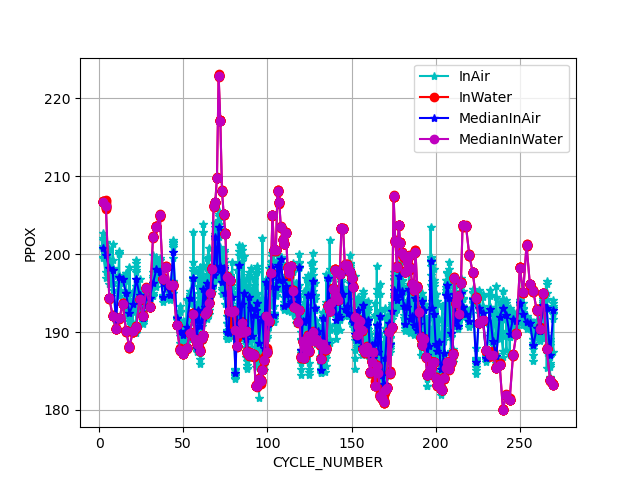

PSAL_ADJUSTED Data is used


In [24]:
# Get ARGO PPOX inair/inwater for NCEP correction
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_InAir_InWater.png'))

In [25]:
# Compute NCEP data at ARGO time
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [26]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

In [27]:
delta_T_NCEP

array([  11.42      ,   31.29668981,   51.41674769,   71.42152778,
         91.41222222,  111.43925926,  131.4172338 ,  151.40842593,
        171.4069213 ,  191.39893519,  211.40471065,  231.4052662 ,
        251.40890046,  271.40328704,  291.40824074,  311.40733796,
        331.40922454,  351.40813657,  371.40511574,  391.40517361,
        411.40761574,  431.41083333,  451.40625   ,  471.40518519,
        491.4022338 ,  511.40541667,  531.40983796,  551.41018519,
        561.41116898,  571.41041667,  581.40788194,  591.40540509,
        601.41260417,  611.40462963,  621.40935185,  631.40740741,
        641.40725694,  651.41081019,  661.41064815,  671.40940972,
        681.40305556,  691.4080787 ,  701.4094213 ,  711.40334491,
        721.40944444,  731.4094213 ,  741.40511574,  751.40497685,
        761.41068287,  771.41123843,  781.40768519,  791.40702546,
        801.41273148,  811.40929398,  821.40763889,  831.42201389,
        841.41515046,  851.42836806,  861.42273148,  871.42207

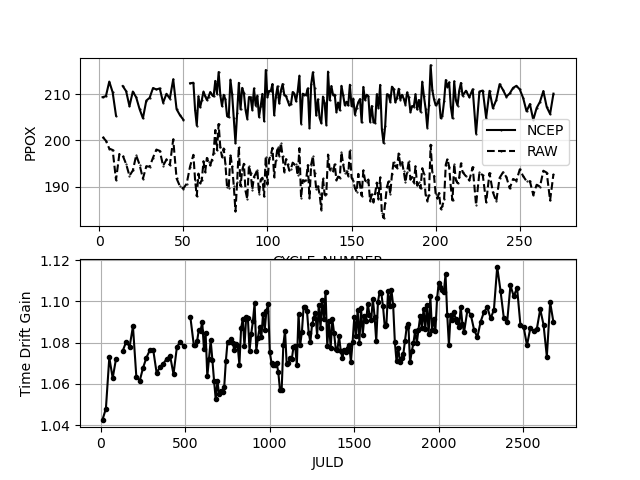

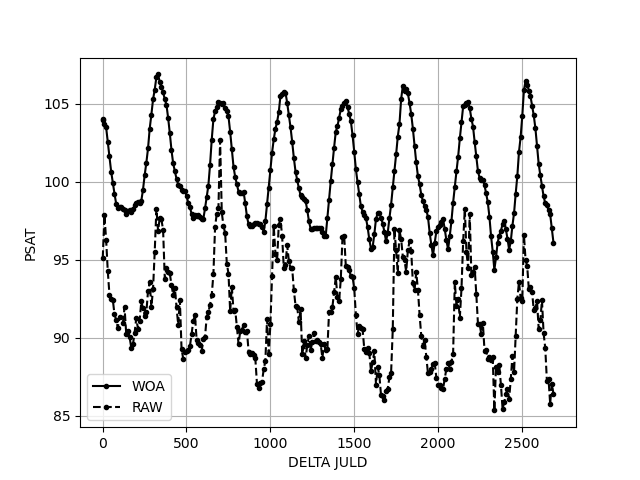

In [28]:
dict_corr = {}
deltaT_list=[[]] 
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
_=plot_cmp_corr_WOA(dict_corr,deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

Breakpoints (X) : [  11.42         52.86331326 2680.16547454]
Breaks : [  11.42         52.86331326 2680.16547454]
Slopes : [7.53589864e-04 1.02226560e-05]
Intercepts : [1.03081559 1.07011244]


Correction NCEP : Traitement du Segment 1

Valeurs par calcul : 1.0308155860433765,26.68375449509183
popt : [7.54114468e-04 1.03080564e+00], error : [0.00027865 0.00985651]
Gain/Derive NCEP : [ 1.03081559 26.6837545 ]
Erreur Gain/Derive NCEP : [9.85650864e-03 9.87001715e+00]
Le segment 1 dure moins de 90 jours : Pas d'estimation du carryOver
Gain/Derive NCEP : [ 1.03081559 26.6837545 ]
Error GAin/Derive NCEP  : [9.85650864e-03 9.87001715e+00]


Correction NCEP : Traitement du Segment 2

Valeurs par calcul : 1.070112439617547,0.34868012994042724
popt : [1.02229402e-05 1.07011195e+00], error : [1.08009082e-06 1.65097536e-03]
Gain/Derive NCEP : [1.07011244 0.34868013]
Erreur Gain/Derive NCEP : [0.00165098 0.03684428]
Le segment 2 dure plus de 90 jours : Estimation du carryOver
GAin/Derive NCEP Car

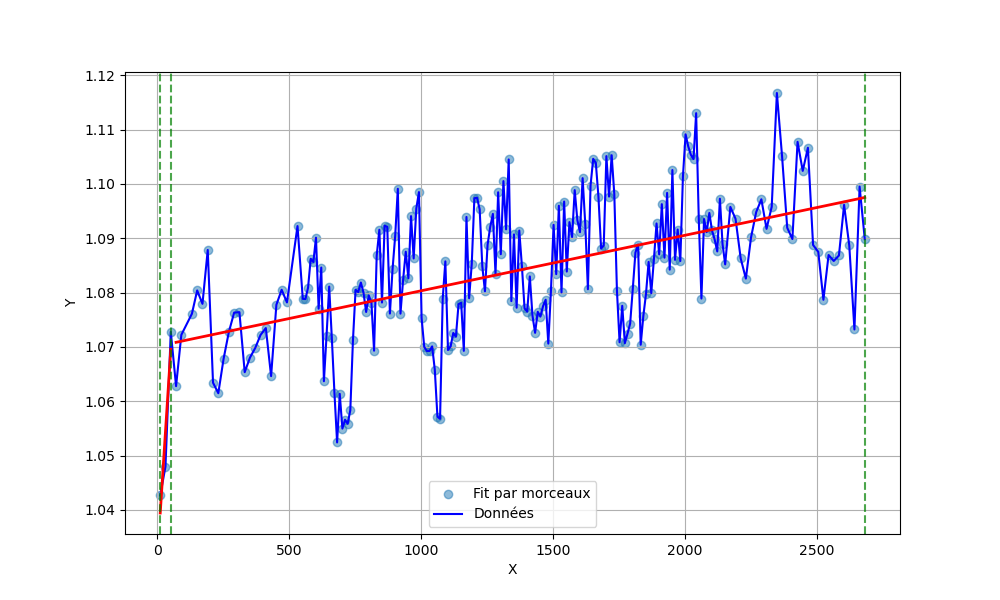

In [29]:
params_morceaux_Gain_Derive_NCEP = []
params_morceaux_Gain_Derive_CarryOver = []
perr_morceaux_Gain_Derive_NCEP = []
perr_morceaux_Gain_Derive_CarryOver = []

PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
bid = NCEP_PPOX/dsair['PPOX_DOXY']
mask = bid.notnull()
y_noisy = bid[mask]
x = delta_T_NCEP[mask]
#best_n_breakpoints = 0
#best_mse = float('inf')
#for n_breakpoints in range(1,3):
#    print(n_breakpoints)
#    model = pwlf.PiecewiseLinFit(x, y_noisy)
#    model.fit(n_breakpoints)
#    y_pred = model.predict(x)
#    mse = np.mean((y_pred - y_noisy) ** 2)
#    if mse < best_mse:
#        best_mse = mse
#        best_n_breakpoints = n_breakpoints

nb_segment = 2
model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment)

breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
#x_pred = np.linspace(min(x), max(x), 200)
x_pred = delta_T_NCEP
y_pred = model.predict(x_pred)

# Affichage des résultats
#plt.figure(figsize=(10, 6))
#plt.scatter(x, y_noisy, label="Données bruitées", color="blue", alpha=0.5)
#plt.plot(x_pred, y_pred, color="red", label="Correction par morceaux")
#plt.vlines(breakpoints, ymin=min(y_noisy), ymax=max(y_noisy), colors="green", linestyles="dashed", label="Breakpoints")
#plt.xlabel("Valeur instrumentale (X)")
#plt.ylabel("Valeur de référence (Y)")
#plt.title("Correction par morceaux avec continuité")
#plt.legend()
#plt.grid(True)
#plt.show()

plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_NCEP = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept

def model_bid(X,A,B):
    return (A*X + B)
    
nb_day_carryover = 90
for i in range(nb_segment):
    print(f"\n\nCorrection NCEP : Traitement du Segment {i+1}\n")
    x0, x1 = breaks_NCEP[i], breaks_NCEP[i+1]
    mask = (delta_T_NCEP >=x0) & (delta_T_NCEP<=x1)
    xs = delta_T_NCEP[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_ncep = intercepts[i]
    drift_ncep = slopes[i] * 36500/slope_ncep
    print(f"Valeurs par calcul : {slope_ncep},{drift_ncep}")

    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = NCEP_PPOX/dsair['PPOX_DOXY']
    popt, pcov = curve_fit(model_bid, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_NCEP = np.sqrt(np.diag(pcov))
    print(f"popt : {popt}, error : {perr_bid_NCEP}")
    
    var1_seg = PPOX1[mask]
    var2_seg = PPOX2[mask]
    delta_T_seg = delta_T_NCEP[mask]
    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    #val_bid1,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], NCEP_PPOX[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    #print(f"val_bid NCEP 1: {val_bid1}")
    #print(f"Erreur Gain/Derive NCEP : {np.sqrt(np.diag(covariance))}")

    val_bid_NCEP,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    # perr_bid_NCEP = np.sqrt(np.diag(covariance)) # Les erreurs sont mal estimees (infimes voire nulles).
    
    #
    # Calcul de l'erreur sur slope et drift final.
    #
    perr_bid_NCEP_final = perr_bid_NCEP.copy()
    perr_bid_NCEP_final[0] = perr_bid_NCEP[1]
    perr_bid_NCEP_final[1] = 36500 * np.sqrt( (perr_bid_NCEP[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_NCEP[1]) / (intercepts[i]**2))**2 )
    perr_morceaux_Gain_Derive_NCEP.append(perr_bid_NCEP_final)
    print(f"Gain/Derive NCEP : {val_bid_NCEP}")
    print(f"Erreur Gain/Derive NCEP : {perr_bid_NCEP_final}")


    params_morceaux_Gain_Derive_NCEP.append(val_bid_NCEP)

    if (breaks_NCEP[i+1]-breaks_NCEP[i]>nb_day_carryover):
        print(f"Le segment {i+1} dure plus de {nb_day_carryover} jours : Estimation du carryOver")
        initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
        val_bid_NCEP_CarryOver, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit',full_output=True)
        print(f"GAin/Derive NCEP CarryOver : {val_bid_NCEP_CarryOver}")
        #val_bid2, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],ys*dsair['PPOX_DOXY'][mask],p0=initial_guess,nan_policy='omit',full_output=True)
        #print(f"val_bid NCEP CarryOver2: {val_bid2}")
        params_morceaux_Gain_Derive_CarryOver.append(val_bid_NCEP_CarryOver)  
        perr_bid_CarryOver = np.sqrt(np.diag(covariance))
        print(f"Error GAin/Derive NCEP CarryOver : {perr_bid_CarryOver}")
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid_CarryOver)

    else:
        print(f"Le segment {i+1} dure moins de {nb_day_carryover} jours : Pas d'estimation du carryOver")
        print(f"Gain/Derive NCEP : {val_bid_NCEP}")
        print(f"Error GAin/Derive NCEP  : {perr_bid_NCEP_final}")
        val_bid = np.array([val_bid_NCEP[0],0,val_bid_NCEP[1]])
        perr_bid = np.array([perr_bid_NCEP_final[0],0,perr_bid_NCEP_final[1]])
        params_morceaux_Gain_Derive_CarryOver.append(val_bid)   
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid)

        
    
for b in breaks_NCEP:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

Breakpoints (X) : [1.38194444e+00 2.22055739e+03 2.68995486e+03]
Breaks : [1.38194444e+00 2.22055739e+03 2.68995486e+03]
Slopes : [4.69729220e-06 3.87947514e-05]
Intercepts : [1.08965207 1.0139367 ]


Correction WOA : Traitement du Segment 1

Valeurs par calcul : 1.0896520672072478,0.15734487238787392
popt : [4.63109153e-06 1.08970127e+00], error : [1.70211216e-06 2.19093975e-03]
val_bid WOA1: [1.08970126 0.15512044]
val_bid WOA2: [1.08965207 0.15734487] error : [0.00219094 0.05701641]


Correction WOA : Traitement du Segment 2

Valeurs par calcul : 1.0139367023242107,1.396545190206569
popt : [3.73109680e-05 1.01770067e+00], error : [1.66021756e-05 4.09006255e-02]
val_bid WOA1: [1.01770056 1.33816561]
val_bid WOA2: [1.0139367  1.39654519] error : [0.04090063 0.60029931]


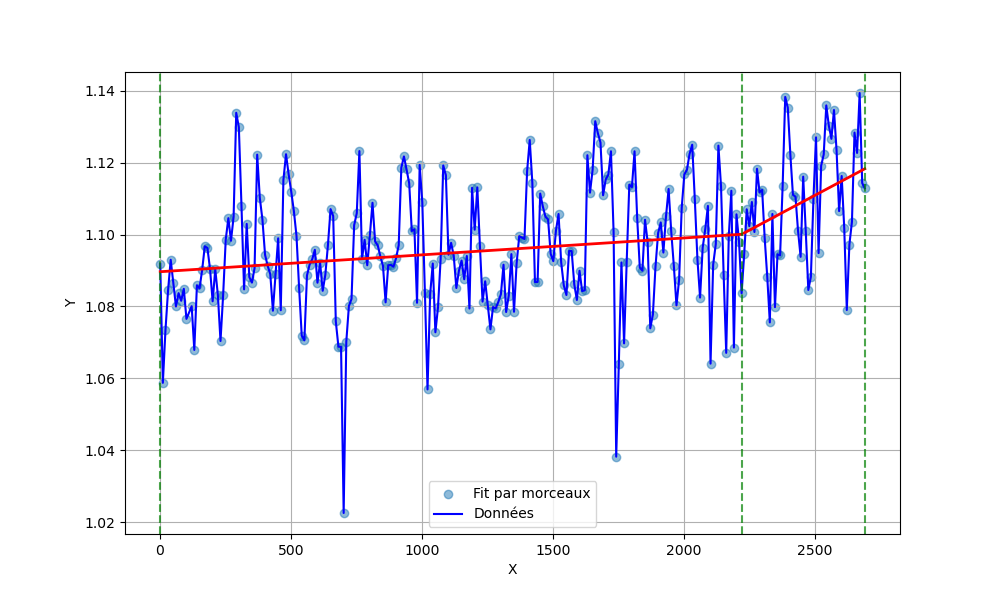

In [30]:
params_morceaux_Gain_Derive_WOA = []
perr_morceaux_Gain_Derive_WOA = []
bid = ppox_WOA_mean/ppox_ARGO_mean
mask = ~np.isnan(bid)
y_noisy = bid[mask]
x = delta_T_WOA[mask]
#best_n_breakpoints = 0
#best_mse = float('inf')
#for n_breakpoints in range(1,3):
#    print(n_breakpoints)
#    model = pwlf.PiecewiseLinFit(x, y_noisy)
#    model.fit(n_breakpoints)
#    y_pred = model.predict(x)
#    mse = np.mean((y_pred - y_noisy) ** 2)
#    if mse < best_mse:
#        best_mse = mse
#        best_n_breakpoints = n_breakpoints

nb_segment = 2
model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment)
breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
#x_pred = np.linspace(min(x), max(x), 200)
x_pred = delta_T_NCEP
y_pred = model.predict(x_pred)

# Affichage des résultats
#plt.figure(figsize=(10, 6))
#plt.scatter(x, y_noisy, label="Données bruitées", color="blue", alpha=0.5)
#plt.plot(x_pred, y_pred, color="red", label="Correction par morceaux")
#plt.vlines(breakpoints, ymin=min(y_noisy), ymax=max(y_noisy), colors="green", linestyles="dashed", label="Breakpoints")
#plt.xlabel("Valeur instrumentale (X)")
#plt.ylabel("Valeur de référence (Y)")
#plt.title("Correction par morceaux avec continuité")
#plt.legend()
#plt.grid(True)
#plt.show()

plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_WOA = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept

for i in range(nb_segment):
    print(f"\n\nCorrection WOA : Traitement du Segment {i+1}\n")
    x0, x1 = breaks_WOA[i], breaks_WOA[i+1]
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_ncep = intercepts[i]
    drift_ncep = slopes[i] * 36500/slope_ncep
    print(f"Valeurs par calcul : {slope_ncep},{drift_ncep}")

    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = ppox_WOA_mean/ppox_ARGO_mean
    popt, pcov = curve_fit(model_bid, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_WOA = np.sqrt(np.diag(pcov))
    print(f"popt : {popt}, error : {perr_bid_WOA}")

    perr_bid_WOA_final = perr_bid_WOA.copy()
    perr_bid_WOA_final[0] = perr_bid_WOA[1]
    perr_bid_WOA_final[1] = 36500 * np.sqrt( (perr_bid_WOA[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_WOA[1]) / (intercepts[i]**2))**2 )

    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    var1_seg = ppox_ARGO_mean[mask]
    delta_T_seg = delta_T_WOA[mask]
    val_bid1,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ppox_WOA_mean[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    print(f"val_bid WOA1: {val_bid1}")
    val_bid2,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    #perr_bid = np.sqrt(np.diag(covariance))
    perr_morceaux_Gain_Derive_WOA.append(perr_bid_WOA_final)
    print(f"val_bid WOA2: {val_bid2} error : {perr_bid_WOA_final}")
    params_morceaux_Gain_Derive_WOA.append(val_bid2)   
        
    
for b in breaks_WOA:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

In [31]:
params_morceaux_Gain_Derive_NCEP = np.array(params_morceaux_Gain_Derive_NCEP)
params_morceaux_Gain_Derive_CarryOver = np.array(params_morceaux_Gain_Derive_CarryOver)
params_morceaux_Gain_Derive_CarryOver = params_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
params_morceaux_Gain_Derive_WOA = np.array(params_morceaux_Gain_Derive_WOA)

perr_morceaux_Gain_Derive_NCEP = np.array(perr_morceaux_Gain_Derive_NCEP)
perr_morceaux_Gain_Derive_CarryOver = np.array(perr_morceaux_Gain_Derive_CarryOver)
perr_morceaux_Gain_Derive_CarryOver = perr_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
perr_morceaux_Gain_Derive_WOA = np.array(perr_morceaux_Gain_Derive_WOA)
print(f"{params_morceaux_Gain_Derive_NCEP}\n{params_morceaux_Gain_Derive_CarryOver}\n{params_morceaux_Gain_Derive_WOA}\n")
print(f"{perr_morceaux_Gain_Derive_NCEP}\n{perr_morceaux_Gain_Derive_CarryOver}\n{perr_morceaux_Gain_Derive_WOA}\n")

[[ 1.03081559 26.6837545 ]
 [ 1.07011244  0.34868013]]
[[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
[[1.08965207 0.15734487]
 [1.0139367  1.39654519]]

[[9.85650864e-03 9.87001715e+00]
 [1.65097536e-03 3.68442754e-02]]
[[9.85650864e-03 9.87001715e+00]
 [1.40662470e-03 3.19417047e-02]]
[[0.00219094 0.05701641]
 [0.04090063 0.60029931]]



Gain/Derive Ncep morceaux
Number of pieces : 2
[ 1.03081559 26.6837545 ]
[1.07011244 0.34868013]
Gain/Derive Ncep CarryOver Morceaux
Number of pieces : 2
[ 1.03081559 26.6837545 ]
[1.07034291 0.33679822]
Gain/Derive WOA morceaux
Number of pieces : 2
[1.08965207 0.15734487]
[1.0139367  1.39654519]
Gain/Derive Ncep morceaux
Number of pieces : 2
[ 1.03081559 26.6837545 ]
[1.07011244 0.34868013]
Gain/Derive Ncep CarryOver Morceaux
Number of pieces : 2
[ 1.03081559 26.6837545 ]
[1.07034291 0.33679822]
Gain/Derive WOA morceaux
Number of pieces : 2
[1.08965207 0.15734487]
[1.0139367  1.39654519]


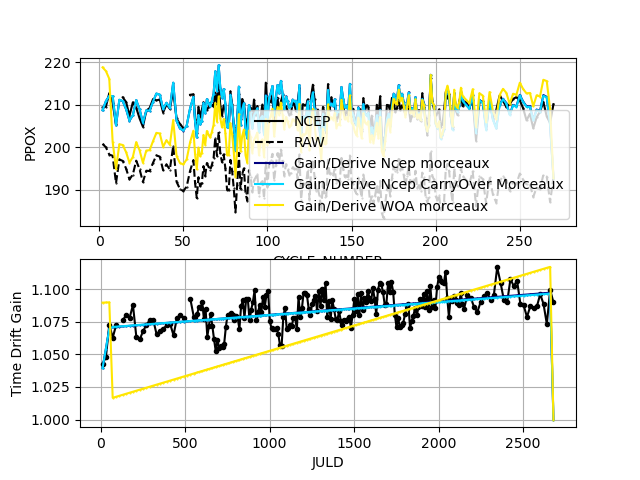

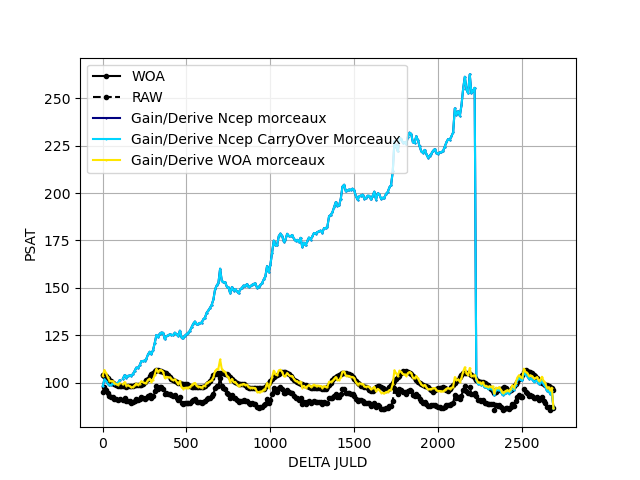

In [32]:
# Compare NCEP and WOA with the NCEP correction with Carryover (with and without piece)
dict_corr = {'Gain/Derive Ncep morceaux' : params_morceaux_Gain_Derive_NCEP,'Gain/Derive Ncep CarryOver Morceaux' : params_morceaux_Gain_Derive_CarryOver,
            'Gain/Derive WOA morceaux' : params_morceaux_Gain_Derive_WOA}
deltaT_list = np.repeat([breaks_NCEP], len(dict_corr), axis=0)
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_piece_NCEP.png'))
deltaT_list = np.repeat([breaks_WOA], len(dict_corr), axis=0)
_=plot_cmp_corr_WOA(dict_corr,deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_piece_WOA.png'))


In [33]:
perr_morceaux_Gain_Derive_WOA

array([[0.00219094, 0.05701641],
       [0.04090063, 0.60029931]])

In [34]:
for i in range(len(params_morceaux_Gain_Derive_WOA)):
    gain, drift = params_morceaux_Gain_Derive_WOA[i]
    egain, edrift = perr_morceaux_Gain_Derive_WOA[i]
    print(f"Segment {i+1} WOA : "
          f"Gain/Drift {gain:.4f}/{drift:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}")

for i in range(len(params_morceaux_Gain_Derive_NCEP)):
    gain, drift = params_morceaux_Gain_Derive_NCEP[i]
    egain, edrift = perr_morceaux_Gain_Derive_NCEP[i]
    print(f"Segment {i+1} NCEP : "
          f"Gain/Drift {gain:.4f}/{drift:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}")

for i in range(len(params_morceaux_Gain_Derive_CarryOver)):
    gain, drift = params_morceaux_Gain_Derive_CarryOver[i]
    egain, edrift = perr_morceaux_Gain_Derive_CarryOver[i]
    print(f"Segment {i+1} NCEP CarryOver: "
          f"Gain/Drift {gain:.4f}/{drift:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}")

Segment 1 WOA : Gain/Drift 1.0897/0.1573  with Error  0.0022/0.0570
Segment 2 WOA : Gain/Drift 1.0139/1.3965  with Error  0.0409/0.6003
Segment 1 NCEP : Gain/Drift 1.0308/26.6838  with Error  0.0099/9.8700
Segment 2 NCEP : Gain/Drift 1.0701/0.3487  with Error  0.0017/0.0368
Segment 1 NCEP CarryOver: Gain/Drift 1.0308/26.6838  with Error  0.0099/9.8700
Segment 2 NCEP CarryOver: Gain/Drift 1.0703/0.3368  with Error  0.0014/0.0319


In [35]:
# Which correction to keep/apply
# Here, the user must decide which correction to keep to estimate a supplement gain with CTD.
# 
# corr_to_keep = 1 ==> WOA GAIN
# corr_to_keep = 2 ==> WOA Gain/Drift
# corr_to_keep = 3 ==> NCEP Gain without CarryOver
# corr_to_keep = 4 ==> NCEP Gain with CarryOver
# corr_to_keep = 5 ==> NCEP Gain/Drift without CarryOver
# corr_to_keep = 6 ==> NCEP Gain/Drift with CarryOver

corr_to_keep = 8
match corr_to_keep:
    case 1:
        params_to_keep = copy.deepcopy(params_Gain_WOA)
        comment_corr = 'Correction with a WOA Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_WOA)
        nb_param = 1
    case 2:
        params_to_keep = copy.deepcopy(params_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_WOA)
        nb_param = 2
    case 3:
        params_to_keep = copy.deepcopy(params_Gain_NCEP)
        comment_corr = 'Correction with a NCEP Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_NCEP)
        nb_param = 1
    case 4:
        params_to_keep = copy.deepcopy(params_Gain_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain'
        perr_to_keep = perr_Gain_NCEP_CarryOver[0]
        nb_param = 1
    case 5:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP)
        comment_corr = 'Correction with a NCEP Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_NCEP)
        nb_param = 2
    case 6:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_Gain_Derive_NCEP_CarryOver[[0,2]]
        nb_param = 2

    case 7 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_NCEP)
        comment_corr = 'Correction by piece with a NCEP  Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_NCEP
        nb_param = 2
        breaks_to_keep = breaks_NCEP

    case 8 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_CarryOver)
        comment_corr = 'Correction by piece with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_CarryOver
        nb_param = 2
        breaks_to_keep = breaks_NCEP


    case 9 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_WOA)
        comment_corr = 'Correction with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_WOA
        nb_param = 2
        breaks_to_keep = breaks_WOA


print(comment_corr)
print(f'Correction used :  {params_to_keep}')
print(f'Error on correction : {perr_to_keep}')
print(f'BreaksPoints : {breaks_to_keep}')


Correction by piece with a NCEP CarryOver Gain/Drift
Correction used :  [[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
Error on correction : [[9.85650864e-03 9.87001715e+00]
 [1.40662470e-03 3.19417047e-02]]
BreaksPoints : [  11.42         52.86331326 2680.16547454]


In [36]:
print(params_to_keep)
print(perr_to_keep)

[[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
[[9.85650864e-03 9.87001715e+00]
 [1.40662470e-03 3.19417047e-02]]


delta_T_en_cours [1.38194444]
[ 1.03081559 26.6837545 ]
[1.03861683] [0.00081172]
[1.03765243] [0.00099501]
Supplement Gain from CTD (without effect pressure) :  1.0386


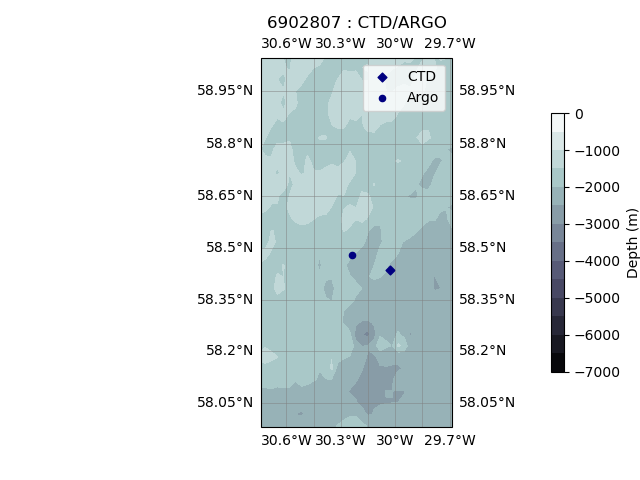

In [37]:
# We estimate a supplement Gain from the CTD without pressure effect.
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
perr_Gain_CTD = np.array([0])
ppox_cruise_tot = np.array([])
doxy_cruise_tot = np.array([])
ppox_cycle_corr_tot = np.array([])
doxy_cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])

# Compare ARGO Profil  with  CTD. We compare OXYGEN directly
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        _=plot_CTD_Argo_Pos(ds_argo_Sprof, ds_bathy,depths,extend_lon_lat,rep_ctd,fic_ctd,num_ctd,num_cycle)
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_CTD_argo.png'))

        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)

        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        doxy_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        ppox_cruise_tot = np.concatenate((ppox_cruise_tot,ppox_cruise_interp),axis=None)
        doxy_cruise_tot = np.concatenate((doxy_cruise_tot,doxy_cruise_interp),axis=None)
        
        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        print(f"delta_T_en_cours {delta_T_Sprof}")
        if len(breaks_to_keep)>0:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        print(params_ok)
        
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        ana_dens_cycle = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP_ADJUSTED'].isel(N_PROF=0),ds_cycle['PSAL_ADJUSTED'].isel(N_PROF=0),ds_cycle['PRES_ADJUSTED'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_ok)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_ok)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)


        ppox_cycle_corr_tot = np.concatenate((ppox_cycle_corr_tot,ppox_cycle_corr),axis=None)
        doxy_cycle_corr_tot = np.concatenate((doxy_cycle_corr_tot,doxy_cycle_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)
 
    
    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD_V2, covariance = curve_fit(model_Gain, ppox_cycle_corr_tot, ppox_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD_V2 = np.sqrt(np.diag(covariance))

    params_Gain_CTD, covariance = curve_fit(model_Gain, doxy_cycle_corr_tot, doxy_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD = np.sqrt(np.diag(covariance))
    
    print(params_Gain_CTD,perr_Gain_CTD)
    print(params_Gain_CTD_V2,perr_Gain_CTD_V2)

    print("Supplement Gain from CTD (without effect pressure) : ",",".join(f"{val:.4f}" for val in params_Gain_CTD))

[[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
delta_T_en_cours [1.38194444]
[ 1.03081559 26.6837545 ]
Pressure effect Estimation
CTD pressure effect estimated with pressure effect : 0.041534 with error 0.000808
CTD Gain estimated with pressure effect : 1.041348 with error 0.001034


/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_12903/4129387444.py:99: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _=plt.legend([h1,h2,h3,h4],['CTD','ARGO Corr','ARGO Corr Data used','CTD Data used'])


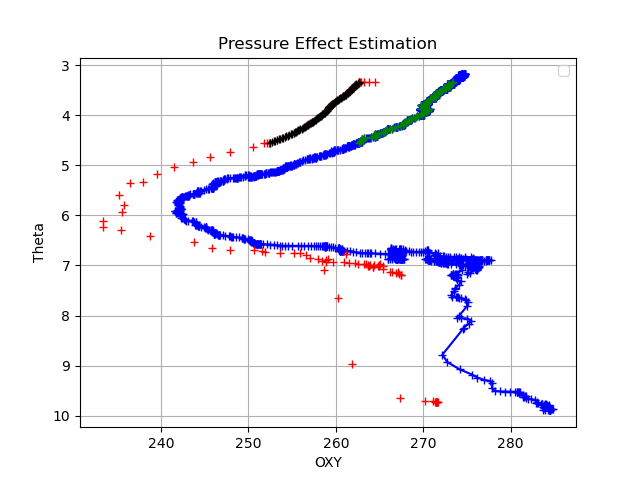

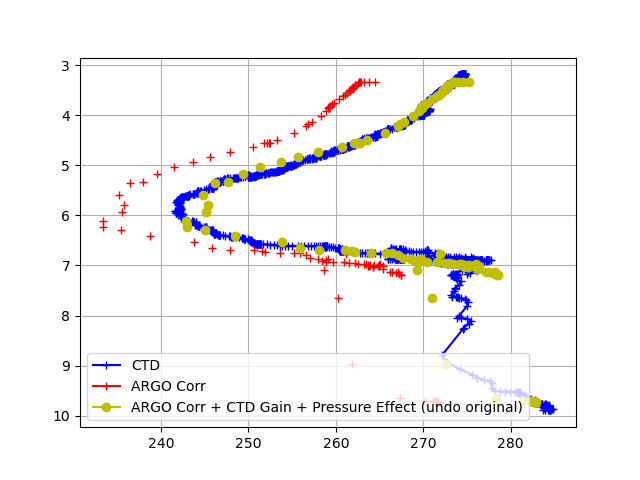

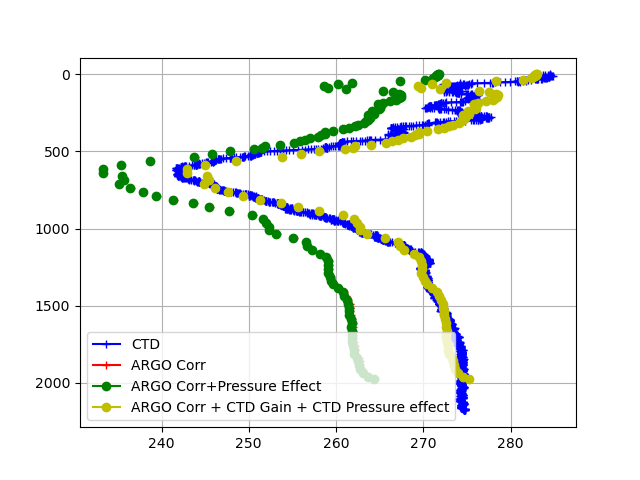

In [38]:
from scipy.interpolate import interp1d

# We estimate a pressure effect by using potentaol temperature.
# Init Pressure correction (0 by default) and a supplement gain from CTD (1 by default)
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])
perr_pressure = np.array([0,0])

print(params_to_keep)
# Pressure effect estimation.
# We compare ARGO O2 with CTD O2.
# According to V. Thierry, we must estimate a Gain and a pressure effect.
# Estimate only a pressure effect seems to be incorrect.
# We do thatfrom the 'first' correction.
strvar = '_ADJUSTED'
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)

        print(f"delta_T_en_cours {delta_T_Sprof}")
        if len(breaks_to_keep)>0:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep

        print(params_ok)
        
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))
        
        if nb_param == 1:
            doxy_ARGO_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            doxy_ARGO_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)

        # Compute ARGO and CTD theta.
        psal_cycle = ds_cycle['PSAL'+strvar].values
        pres_cycle = ds_cycle['PRES'+strvar].values 
        temp_cycle = ds_cycle['TEMP'+strvar].values
        theta_cycle = sw.ptmp(psal_cycle,temp_cycle,pres_cycle,0)

        psal_cruise = ds_cruise['PSAL'].values
        pres_cruise = ds_cruise['PRES'].values
        temp_cruise = ds_cruise['TEMP'].values
        theta_cruise = sw.ptmp(psal_cruise,temp_cruise,pres_cruise,0)

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],theta_cruise[0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],theta_cycle[0],'+-r')

        theta_common = np.linspace(max(np.nanmin(theta_cycle), np.nanmin(theta_cruise)),
                                   min(np.nanmax(theta_cycle), np.nanmax(theta_cruise)),
                                   500)

        valid = ~np.isnan(theta_cycle[0]) & ~np.isnan(doxy_ARGO_corr[0])
        # Defintion fonction interpolation.
        interp_o2_cycle = interp1d(theta_cycle[0][valid], doxy_ARGO_corr[0][valid], bounds_error=False, fill_value=np.nan)
        interp_o2_cruise = interp1d(theta_cruise[0], ds_cruise['OXYK'][0], bounds_error=False, fill_value=np.nan)
        interp_pres_cycle = interp1d(theta_cycle[0], pres_cycle[0], bounds_error=False, fill_value=np.nan)
        interp_temp_cycle = interp1d(theta_cycle[0], temp_cycle[0], bounds_error=False, fill_value=np.nan)

        # Interpolation on theta communs entre CTD and ARGO
        o2_cycle_theta = interp_o2_cycle(theta_common)
        o2_cruise_theta = interp_o2_cruise(theta_common)
        p_cycle_theta = interp_pres_cycle(theta_common)
        temp_cycle_theta = interp_temp_cycle(theta_common)

        # Remove Nan Values
        valid = ~np.isnan(o2_cycle_theta) & ~np.isnan(o2_cruise_theta) & ~np.isnan(p_cycle_theta)
        o2_cycle_theta = o2_cycle_theta[valid]
        o2_cruise_theta = o2_cruise_theta[valid]
        p_cycle_theta = p_cycle_theta[valid]
        temp_cycle_theta = temp_cycle_theta[valid]
        theta_common = theta_common[valid]

        
        PRES_1D = p_cycle_theta.squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres = p_cycle_theta[mask]
        temp_pour_pres = temp_cycle_theta[mask]
        doxy_cruise_pour_pres = o2_cruise_theta[mask]
        doxy_cycle_pour_pres = o2_cycle_theta[mask]


       
        h3=plt.plot(doxy_cycle_pour_pres,theta_common[mask],'+-k')
        h4=plt.plot(doxy_cruise_pour_pres,theta_common[mask],'+-g')
        plt.gca().invert_yaxis()
        plt.grid()
        plt.xlabel('OXY')
        plt.ylabel('Theta')
        _=plt.legend([h1,h2,h3,h4],['CTD','ARGO Corr','ARGO Corr Data used','CTD Data used'])
        plt.title('Pressure Effect Estimation')
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effect.png'))

        print('Pressure effect Estimation')
        initial_guess = [1,0]   
        #params_corr_pressure, covariance = curve_fit(model_corr_pres, [(cycle_pour_pres*doxy_cruise_mean/doxy_argo_mean)[0].values,pres_pour_pres[0].values], oxy_pour_pres, p0=initial_guess,nan_policy='omit') 
        #params_corr_pressure, covariance = curve_fit(model_Gain_pres, [doxy_cycle_pour_pres,pres_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit') 
        params_corr_pressure, covariance = curve_fit(lambda X, G, Gp: model_Gain_pres(X, G, Gp, pcoef2, pcoef3),
                       [doxy_cycle_pour_pres,pres_pour_pres,temp_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit')
        perr_pressure = np.sqrt(np.diag(covariance))
        print(f'CTD pressure effect estimated with pressure effect : {params_corr_pressure[1]:.6f} with error {perr_pressure[1]:.6f}')
        print(f'CTD Gain estimated with pressure effect : {params_corr_pressure[0]:.6f} with error {perr_pressure[0]:.6f}')

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],theta_cruise[0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],theta_cycle[0],'+-r')
        h3=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],theta_cycle[0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0],h4[0]],['CTD','ARGO Corr','ARGO Corr + CTD Gain + Pressure Effect (undo original)'])
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effect_corr.png'))

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],ds_cycle['PRES'][0],'+-r')
        h3=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+ params_corr_pressure[1])*ds_cycle['PRES'][0]/1000),ds_cycle['PRES'][0],'o-g')  
        h4=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],ds_cycle['PRES'][0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0], h4[0]],['CTD','ARGO Corr','ARGO Corr+Pressure Effect','ARGO Corr + CTD Gain + CTD Pressure effect'])
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effet_res.png'))

        params_Gain_CTD_with_pressure = np.array([params_corr_pressure[0]])
        params_corr_pressure = np.array([params_corr_pressure[1]])


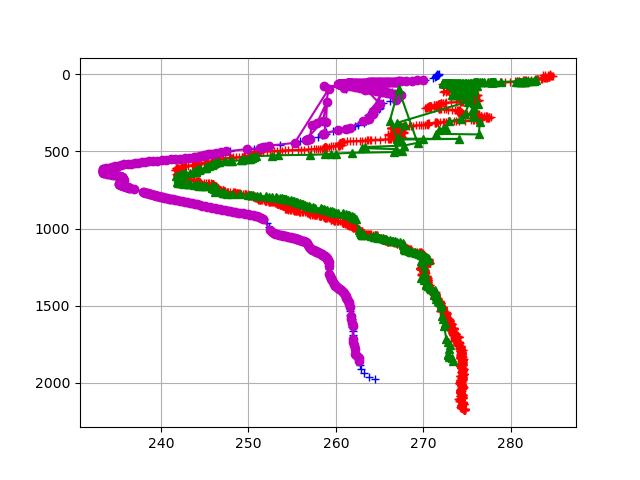

In [39]:
plt.figure()
h1 = plt.plot(doxy_ARGO_corr[0],pres_cycle[0],'+-b')
h2 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-r')
plt.gca().invert_yaxis()
h3 = plt.plot(o2_cycle_theta,p_cycle_theta,'o-m')
h4 = plt.plot(o2_cruise_theta,p_cycle_theta,'^-g')
plt.grid()

In [40]:
print(perr_to_keep)

[[9.85650864e-03 9.87001715e+00]
 [1.40662470e-03 3.19417047e-02]]


In [41]:
# Compute final correction with or without pressure effect.
print(perr_to_keep)
perr_to_keep = np.append(perr_to_keep, np.zeros((perr_to_keep.shape[0],1)), axis=1)
print(perr_to_keep)
#if nb_param == 1:
#    derive_final = 0
#    perr_to_keep = np.append(perr_to_keep, 0) # error on drift
#    perr_to_keep = np.append(perr_to_keep, 0) # error on pressure effect
#else :
#    derive_final = params_to_keep[1]
#    perr_to_keep = np.append(perr_to_keep, 0) # error on pressure effect    
#print(perr_to_keep)

[[9.85650864e-03 9.87001715e+00]
 [1.40662470e-03 3.19417047e-02]]
[[9.85650864e-03 9.87001715e+00 0.00000000e+00]
 [1.40662470e-03 3.19417047e-02 0.00000000e+00]]


In [51]:
print(params_to_keep)
print(params_corr_pressure)
corr_final_without_pressure_correction = np.append(params_to_keep, np.zeros((params_to_keep.shape[0],1)), axis=1) # Ajout colonne de 0 pour effet de pression
corr_final_with_pressure_correction = np.append(params_to_keep, np.full((params_to_keep.shape[0],1),params_corr_pressure[0]), axis=1)
corr_final_CTD_without_pressure_correction = corr_final_without_pressure_correction.copy()
corr_final_CTD_without_pressure_correction[:,0] = corr_final_CTD_without_pressure_correction[:,0] * params_Gain_CTD[0]
corr_final_CTD_with_pressure_correction = corr_final_with_pressure_correction.copy()
corr_final_CTD_with_pressure_correction[:,0] = corr_final_CTD_with_pressure_correction[:,0] * params_Gain_CTD[0]

perr_final = perr_to_keep # correction to keep
perr_final_pressure = perr_to_keep.copy()
perr_final_pressure[:,2] = perr_pressure[1]
perr_final_CTD = perr_final.copy()
perr_final_CTD[:,0] = np.sqrt(perr_final_CTD[:,0]*perr_final_CTD[:,0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]) # correction to keep with CTD supplement Gain
perr_final_CTD_with_pressure = perr_final_pressure.copy()
perr_final_CTD_with_pressure[:,0] = np.sqrt(perr_final_CTD_with_pressure[:,0]*perr_final_CTD_with_pressure[:,0] + perr_pressure[0]*perr_pressure[0]) # correction to keep with CTD effect pressure and CTD Gain

[[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
[0.04153359]


In [52]:
for i in range(nb_segment):
    gain, drift, pres = corr_final_without_pressure_correction[i]
    egain, edrif, epres = perr_final[i]
    print(f"Segment {i+1} initial Corr : "
          f"Gain/Drift/Pres {gain:.4f}/{drift:.4f}/{pres:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}/{epres:.4f}")

    gain, drift, pres = corr_final_with_pressure_correction[i]
    egain, edrif, epres = perr_final_pressure[i]
    print(f"Segment {i+1} Init_Corr + Pressure : "
          f"Gain/Drift/Pres {gain:.4f}/{drift:.4f}/{pres:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}/{epres:.4f}")

    gain, drift, pres = corr_final_CTD_without_pressure_correction[i]
    egain, edrif, epres = perr_final_CTD[i]
    print(f"Segment {i+1} Init_Corr + Pressure : "
          f"Gain/Drift/Pres {gain:.4f}/{drift:.4f}/{pres:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}/{epres:.4f}")

    gain, drift, pres = corr_final_CTD_with_pressure_correction[i]
    egain, edrif, epres = perr_final_CTD_with_pressure[i]
    print(f"Segment {i+1} Init_Corr + Pressure : "
          f"Gain/Drift/Pres {gain:.4f}/{drift:.4f}/{pres:.4f} "
          f" with Error  {egain:.4f}/{edrift:.4f}/{epres:.4f}")

Segment 1 initial Corr : Gain/Drift/Pres 1.0308/26.6838/0.0000  with Error  0.0099/0.0319/0.0000
Segment 1 Init_Corr + Pressure : Gain/Drift/Pres 1.0308/26.6838/0.0415  with Error  0.0099/0.0319/0.0008
Segment 1 Init_Corr + Pressure : Gain/Drift/Pres 1.0706/26.6838/0.0000  with Error  0.0099/0.0319/0.0000
Segment 1 Init_Corr + Pressure : Gain/Drift/Pres 1.0706/26.6838/0.0415  with Error  0.0099/0.0319/0.0008
Segment 2 initial Corr : Gain/Drift/Pres 1.0703/0.3368/0.0000  with Error  0.0014/0.0319/0.0000
Segment 2 Init_Corr + Pressure : Gain/Drift/Pres 1.0703/0.3368/0.0415  with Error  0.0014/0.0319/0.0008
Segment 2 Init_Corr + Pressure : Gain/Drift/Pres 1.1117/0.3368/0.0000  with Error  0.0016/0.0319/0.0000
Segment 2 Init_Corr + Pressure : Gain/Drift/Pres 1.1117/0.3368/0.0415  with Error  0.0017/0.0319/0.0008


In [53]:
#corr_final_without_pressure_correction = np.array([params_to_keep[0],derive_final,params_no_corr_pressure[0]])
#corr_final_with_pressure_correction = np.array([params_to_keep[0],derive_final,params_corr_pressure[0]])
#corr_final_CTD_without_pressure_correction = np.array([params_Gain_CTD[0] * params_to_keep[0],derive_final,params_no_corr_pressure[0]])
#corr_final_CTD_with_pressure_correction = np.array([params_Gain_CTD_with_pressure[0] * params_to_keep[0],derive_final,params_corr_pressure[0]])
#perr_final = perr_to_keep # correction to keep
#perr_final_pressure = [perr_to_keep[0] ,perr_to_keep[1],perr_pressure[1]] # correction to keep with pressure effect
#perr_final_CTD = [perr_to_keep[0] + perr_Gain_CTD[0],perr_to_keep[1],perr_to_keep[2]] # correction to keep with CTD supplement Gain
#perr_final_CTD_with_pressure = [perr_to_keep[0] + perr_pressure[0],perr_to_keep[1],perr_pressure[1]] # correction to keep with CTD effect pressure and CTD Gain
#perr_final_CTD = [np.sqrt(perr_to_keep[0]*perr_to_keep[0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]),perr_to_keep[1],perr_to_keep[2]] # correction to keep with CTD supplement Gain
#perr_final_CTD_with_pressure = [np.sqrt(perr_to_keep[0]*perr_to_keep[0] + perr_pressure[0]*perr_pressure[0]),perr_to_keep[1],perr_pressure[1]] # correction to keep with CTD effect pressure and CTD Gain

#print("Initial Correction without pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_without_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final))
#print("Initial Correction with pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_with_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_pressure))
#print("Initiale Correction + CTD Correction without pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_CTD_without_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_CTD))
#print("Initial Correction with pressure effect + CTD Correction  (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_CTD_with_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_CTD_with_pressure))

In [69]:
#
# Which correction to apply (without or with pressure correction).
#
corr_to_apply  = 4
if corr_to_apply == 1:
    corr_final_to_use = corr_final_without_pressure_correction
    perr_to_use = perr_final
elif corr_to_apply == 2 :
    corr_final_to_use = corr_final_with_pressure_correction
    comment_corr = comment_corr + ' and a pressure effect'
    perr_to_use = perr_final_pressure
elif corr_to_apply == 3:
    corr_final_to_use = corr_final_CTD_without_pressure_correction
    coment_corr = comment_corr + ' and CTD Gain'
    perr_to_use = perr_final_CTD

else:
    corr_final_to_use = corr_final_CTD_with_pressure_correction
    comment_corr = comment_corr + ' and CTD Gain and pressure effect'
    perr_to_use = perr_final_CTD_with_pressure


print(comment_corr)
print(corr_final_to_use)
print(perr_to_use)

Correction by piece with a NCEP CarryOver Gain/Drift and CTD Gain and pressure effect and CTD Gain and pressure effect
[[ 1.07062242 26.6837545   0.04153359]
 [ 1.11167616  0.33679822  0.04153359]]
[[9.91056243e-03 9.87001715e+00 8.07725595e-04]
 [1.74558821e-03 3.19417047e-02 8.07725595e-04]]


In [59]:
def write_ASCII_file2(fic : str, num_float : str, list_comment : list, list_corr : list, list_error : list) : 
    """ Function to write the coorections estimated in an ASCII file
    
    Parameters
    -----------
    fic : str
        Name of the result file
    num_float : str
        WMO float
    list_comment : list
        Comment for all the corrections
    list_corr : list
        Values of the corrections (slope/drift/pressure effect)
    alignt_number : int
        number of character after the comment to write the values (to align slope/drift/pressure effect in the file)
    """
    max_comment_len = max(len(var) for var in list_comment)
    print(list_corr)
    max_corr_str_len = max(len("/".join(f"{val:.4f}" for val in var)) for var in list_corr)

    with open(fic, "w") as f:
        line = "WMO Float : " + num_float
        f.write(line+ "\n")
        for comment_en_cours,corr_en_cours, error_en_cours in zip(list_comment,list_corr,list_error) :
            print(comment_en_cours,corr_en_cours,error_en_cours)
            comment_str = comment_en_cours.ljust(max_comment_len)
            corr_str =  "/".join(f"{val:.4f}" for val in corr_en_cours) 
            corr_str = corr_str.ljust(max_corr_str_len)
            line = f"{comment_str} {corr_str}"
            if len(error_en_cours) > 0 :
                error_str = "/".join(f"{val:.4f}" for val in error_en_cours)
                line = line + f"   (error : {error_str})"
            f.write(line + "\n")  # une chaîne par ligne
    return None
 

In [66]:
liste_corr = [params_morceaux_Gain_Derive_WOA,
              params_morceaux_Gain_Derive_NCEP,params_morceaux_Gain_Derive_CarryOver,
              corr_final_without_pressure_correction, corr_final_with_pressure_correction,
              corr_final_CTD_without_pressure_correction,corr_final_CTD_with_pressure_correction,
              [],
              corr_final_to_use]

for var in liste_corr:
    print(var)
#max(len("/".join(f"{val:.4f}" for val in var)) for var in liste_corr)

[[1.08965207 0.15734487]
 [1.0139367  1.39654519]]
[[ 1.03081559 26.6837545 ]
 [ 1.07011244  0.34868013]]
[[ 1.03081559 26.6837545 ]
 [ 1.07034291  0.33679822]]
[[ 1.03081559 26.6837545   0.        ]
 [ 1.07034291  0.33679822  0.        ]]
[[ 1.03081559 26.6837545   0.04153359]
 [ 1.07034291  0.33679822  0.04153359]]
[[ 1.07062242 26.6837545   0.        ]
 [ 1.11167616  0.33679822  0.        ]]
[[ 1.07062242 26.6837545   0.04153359]
 [ 1.11167616  0.33679822  0.04153359]]
[]
[[ 1.07062242 26.6837545   0.04153359]
 [ 1.11167616  0.33679822  0.04153359]]


In [60]:
# Écriture dans un fichier ASCII
liste_comment = ["Slope/Drift piece WOA",
                 "Slope/Drift with piece NCEP","Slope/Drift with piece NCEP CarryOver", 
                 "Correction kept without pressure effect",
                 "Correction kept with pressure effect (Slope/Drift/Pressure Effect)",
                 "Correction kept with CTD  (Slope/Drift/Pressure Effect)",
                 "Correction kept with CTD and pressure Effect (Slope/Drift/Pressure Effect)",
                 "\nCorrection to use : ",
                 comment_corr
                ]
liste_corr = [params_morceaux_Gain_Derive_WOA,
              params_morceaux_Gain_Derive_NCEP,params_morceaux_Gain_Derive_CarryOver,
              corr_final_without_pressure_correction, corr_final_with_pressure_correction,
              corr_final_CTD_without_pressure_correction,corr_final_CTD_with_pressure_correction,
              [],
              corr_final_to_use]

liste_error = [perr_morceaux_Gain_Derive_WOA,
              perr_morceaux_Gain_Derive_NCEP,perr_morceaux_Gain_Derive_NCEP,
              perr_final,perr_final_pressure,
              perr_final_CTD,perr_final_CTD_with_pressure,
              [],
              perr_to_use]

write_ASCII_file2(fic_res_ASCII,num_float,liste_comment,liste_corr,liste_error)              
 

[array([[1.08965207, 0.15734487],
       [1.0139367 , 1.39654519]]), array([[ 1.03081559, 26.6837545 ],
       [ 1.07011244,  0.34868013]]), array([[ 1.03081559, 26.6837545 ],
       [ 1.07034291,  0.33679822]]), array([[ 1.03081559, 26.6837545 ,  0.        ],
       [ 1.07034291,  0.33679822,  0.        ]]), array([[ 1.03081559, 26.6837545 ,  0.04153359],
       [ 1.07034291,  0.33679822,  0.04153359]]), array([[ 1.07062242, 26.6837545 ,  0.        ],
       [ 1.11167616,  0.33679822,  0.        ]]), array([[ 1.07062242, 26.6837545 ,  0.04153359],
       [ 1.11167616,  0.33679822,  0.04153359]]), [], array([[ 1.07062242, 26.6837545 ,  0.04153359],
       [ 1.11167616,  0.33679822,  0.04153359]])]


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [127]:
deltaT_list=[[]] * 3
print(deltaT_list)
len(deltaT_list[0])


[[], [], []]


0

In [1]:
# Comparaison correction finale avec NCEP ET PSAT WOA
dict_corr = {'Final Correction' : corr_final_to_use}
deltaT_list=[[]] * len(dict_corr)
tab_error = np.array(perr_to_use)
_=plot_cmp_corr_NCEP_with_error(dict_corr,np.tile(tab_error, (len(dict_corr), 1)),deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_NCEP_final_corr.png'))
_=plot_cmp_corr_WOA_with_error(dict_corr,np.tile(tab_error, (len(dict_corr), 1)),deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_PSATWOA_final_corr.png'))

NameError: name 'corr_final_to_use' is not defined

In [107]:
# BR/BD files correction
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()

print(corr_final_to_use)

for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    first_cycle_to_use = 270
    last_cycle_to_use = 271
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        if nb_segment>1:
            index = next((x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_en_cours),None)
            if index is None :
                if delta_T_en_cours < breaks_to_keep[0] :
                    index = 0
                elif delta_T_en_cours > breaks_to_keep[-1] :
                    index = len(breaks_to_keep) - 1
            if index > 0:
                index = index -1
            corr_final = corr_final_to_use[index,:]
            print(corr_final)
        else :
            corr_final = corr_final_to_use
    
        coef_pres = corr_final[2]
        gain_final = corr_final[0]
        derive_final = corr_final[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000'
        eq_corr = 'DOXY2 = DOXY / (1 + (Pcoef2*TEMP + coef3)*PRES/1000) * (1 + (Pcoef2*TEMP + coef_pres)*PRES/1000),DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)

[[ 1.07062242 26.6837545   0.04153359]
 [ 1.11167616  0.33679822  0.04153359]]
[1.11167616 0.33679822 0.04153359]
Correction de /Volumes/argo/gdac/dac/coriolis/6902807/profiles/BR6902807_270.nc avec [1.11167616 0.33679822 0.04153359]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/R6902807_270.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/R6902807_270.nc pour correction de l'effet de pression

[1.11167616 0.33679822 0.04153359]
Correction de /Volumes/argo/gdac/dac/coriolis/6902807/profiles/BR6902807_271.nc avec [1.11167616 0.33679822 0.04153359]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/R6902807_271.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/R6902807_271.nc pour correction de l'effet de pression



In [105]:
len(breaks_to_keep)

3